# Augmenting with Noise Textures

currently too much overlap here with [make_noise_patches.ipynb](make_noise_patches.ipynb), consider absorbing that into this one

## Introduction: Deep Learning Denoising
Deep convolutional neural networks (CNNs) have been shown to be effective for [CT denoising applications](https://pubs.rsna.org/doi/abs/10.1148/rg.2021200196) as powerful tools for removing noise from CT images and are already being used clinically, both in vendor specific implementations:

| Product          | 510(k) Summary | Assessment | Type | Vendor Specific|
|------------------|:----------:|----------------|------|----------------|
| [Canon AiCE](https://global.medical.canon/products/computed-tomography/aice)|[K192832](https://www.accessdata.fda.gov/cdrh_docs/pdf19/K192832.pdf)|[Brady et al 2021](https://pubs.rsna.org/doi/full/10.1148/radiol.2020202317)|Image Based|Yes|
| [GE True Fidelity DLIR](https://www.gehealthcare.com/products/truefidelity)|[K201745](https://www.accessdata.fda.gov/cdrh_docs/pdf20/K201745.pdf)|[Noda et al 2021](https://doi.org/10.1007/s00261-021-03111-x)| Image Based     | Yes |
| United Imaging Deep Recon| [K193073](https://www.accessdata.fda.gov/cdrh_docs/pdf19/K193073.pdf) | | Image Based | Yes |
| [Philips Precise Image](https://www.philips.com/c-dam/b2bhc/master/resource-catalog/landing/precise-suite/incisive_precise_image.pdf) | [K210760](https://www.accessdata.fda.gov/cdrh_docs/pdf21/K210760.pdf) | | Image Based | Yes |
| [Claripi ClariCT](https://www.claripi.com/clarict-ai/)      | [K183460](https://www.accessdata.fda.gov/cdrh_docs/pdf18/K183460.pdf)|  | Image Based | No |

### Deep Learning Denoisers Learn Image Textures
However, despite deep learning's flexibility to learn challenging computer vision tasks from data, these models are known to not generalize well to data characteristically different than they were trained on. This was shown by a deep learning pneumonia detection model that performed well on internal data, more similar to its training set, than on external data where performance droped [Zech et al., 2018](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002683). Specifically, deep denoising algorithms - often based on deep recurrent layers of convolutions (See [Chen et al 2017]()) - have been shown learn specific frequencies of noise texture via training. [Zeng et al 2022](http://onlinelibrary.wiley.com/doi/abs/10.1002/mp.15430) showed this by testing deep denoisers on sharp kernel test sets after training the models on smooth kernel training data. The noise power spectra of the denoised images revealed that only noise power in the lower spatial frequencies encountered in the training data were removed, leaving the higer frequencies largely untouched.

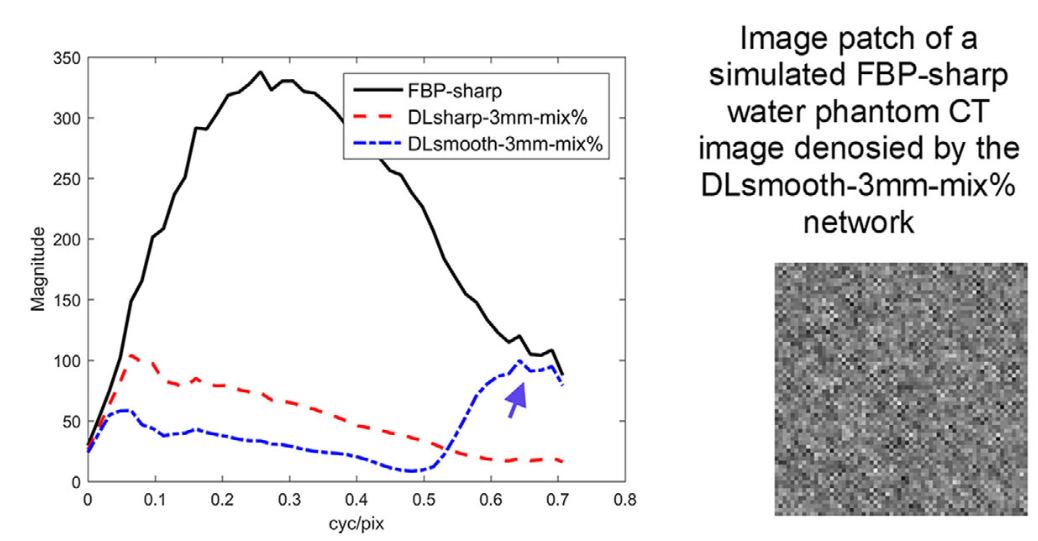

From Figure 8 of [Zeng et al 2022](http://onlinelibrary.wiley.com/doi/abs/10.1002/mp.15430)

### Impact on Pediatric Populations

See also [ITK's discussion of Data Augmentation for Machine Learning](https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/70_Data_Augmentation.html)
- to be sure that we are helping rather than hurting we need to ensure that our augmentations are representative of the natural variability in our intended population, here pediatric patients.

## Aims

**In this notebook** we will do this in two ways:
1. [study the noise power spectra of pediatric patient images, generated via simulation using the XCAT phantoms](#Noise-Texture-from-Pediatric-CT-Simulations)
2. [assess whether this noise power can be reproduced by equal sized water phantoms](#Noise-Texture-from-Pediatric-Sized-Water-Phantom-Simulations)
    - This second step is of practical importance as being able to make these experiments using physical phantoms is an important consideration for making these conclusions usable in the real world where we cannot peform multiple acquisitions on patients.

## Noise Texture from Pediatric CT Simulations

We hypothesize that noise textures are a key difference between adult and pediatric protocols that cause deep learning denoisers to degrade performance when only trained on adult data. The key cause is that noise textures from the smaller field of view pediatric protocols are absent from the adult training data, we aim to demonstrate that here in this section. In the [following section](#Noise-Texture-from-Pediatric-Sized-Water-Phantom-Simulations) we will that this noise textures can be reproduced in phantom scans and integrated into model training via [data augmentation](#Data-Augmentation-with-Pediatric-Protocol-Noise-Patches#Data-Augmentation-with-Pediatric-Protocol-Noise-Patches).

Other notes to self (delete when done):

    Keep phantom scans and patch generation figure in methods 

    Then save the nps texture and intensity histogram comparisons between the phantom patches and anthropomorphic phantoms for the results. This supports that the phantoms can reproduce the noise intensity and textures of the anthropomorphic phantoms (surrogate for peds) and provides more evidence that the augmentation is working by providing noise textures into training that are otherwise missing from the training dataset.

    Then lead into the actual denoising model results in part 2 of the results

In [1]:
import pandas as pd
from pathlib import Path
base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/anthropomorphic/')
df = pd.read_csv(base_dir / 'metadata.csv')
df

Code #          Name  age (year) gender  weight (kg)  \
0    Reference newborn   male infant       0.166      M          3.8   
1    Reference newborn   male infant       0.166      M          3.8   
2    Reference newborn   male infant       0.166      M          3.8   
3    Reference newborn   male infant       0.166      M          3.8   
4    Reference newborn   male infant       0.166      M          3.8   
..                 ...           ...         ...    ...          ...   
415                151  female pt151      66.000      F         66.4   
416                151  female pt151      66.000      F         66.4   
417                151  female pt151      66.000      F         66.4   
418                151  female pt151      66.000      F         66.4   
419                151  female pt151      66.000      F         66.4   

     height (cm)        BMI  weight percentile ethnicity  \
0           52.0  14.100000               36.0       NaN   
1           52.0  14.100000               36.0       NaN   
2           52.0  14.100000               36.0       NaN   
3           52.0  14.100000               36.0       NaN   
4           52.0  14.100000               36.0       NaN   
..           ...        ...                ...       ...   
415        162.0  25.301021               48.8     white   
416        162.0  25.301021               48.8     white   
417        162.0  25.301021               48.8     white   
418        162.0  25.301021               48.8     white   
419        162.0  25.301021               48.8     white   

     effective diameter (cm)  Dose [%]              recon          phantom  \
0                       11.1        10  RED-CNN augmented  anthropomorphic   
1                       11.1        10            RED-CNN  anthropomorphic   
2                       11.1        10                fbp  anthropomorphic   
3                       11.1        40  RED-CNN augmented  anthropomorphic   
4                       11.1        40            RED-CNN  anthropomorphic   
..                       ...       ...                ...              ...   
415                     28.1        70            RED-CNN  anthropomorphic   
416                     28.1        70                fbp  anthropomorphic   
417                     28.1        85  RED-CNN augmented  anthropomorphic   
418                     28.1        85            RED-CNN  anthropomorphic   
419                     28.1        85                fbp  anthropomorphic   

                                                  file  
0    male_infant_ref/diameter111mm/dose_010/RED-CNN...  
1    male_infant_ref/diameter111mm/dose_010/RED-CNN...  
2    male_infant_ref/diameter111mm/dose_010/fbp/mal...  
3    male_infant_ref/diameter111mm/dose_040/RED-CNN...  
4    male_infant_ref/diameter111mm/dose_040/RED-CNN...  
..                                                 ...  
415  female_pt151/diameter281mm/dose_070/RED-CNN/fe...  
416  female_pt151/diameter281mm/dose_070/fbp/female...  
417  female_pt151/diameter281mm/dose_085/RED-CNN au...  
418  female_pt151/diameter281mm/dose_085/RED-CNN/fe...  
419  female_pt151/diameter281mm/dose_085/fbp/female...  

[420 rows x 14 columns]

In [2]:
df['age (year)'].unique()

array([ 0.166,  1.   ,  2.1  ,  2.4  ,  2.8  ,  4.3  ,  5.   ,  5.2  ,
        5.6  , 10.   , 15.   , 27.   , 31.   , 32.   , 44.   , 48.   ,
       52.   , 58.   , 66.   ])

In [3]:
df['effective diameter (cm)'].unique()

array([11.1, 16. , 15.4, 16.2, 16.9, 17.5, 17.9, 16.3, 18.4, 21.3, 24.1,
       23.5, 23.2, 27.7, 28.7, 30.1, 32.1, 34.2, 27.6, 28.1])

In [4]:
import SimpleITK as sitk

def load_img(mhd): return sitk.GetArrayFromImage(sitk.ReadImage(mhd))

vol = load_img(base_dir / df[(df['effective diameter (cm)']==11.1) & (df['Dose [%]'] == 25) & (df['recon'] == 'fbp')].file.item()) - 1000
vol.shape

(10, 512, 512)

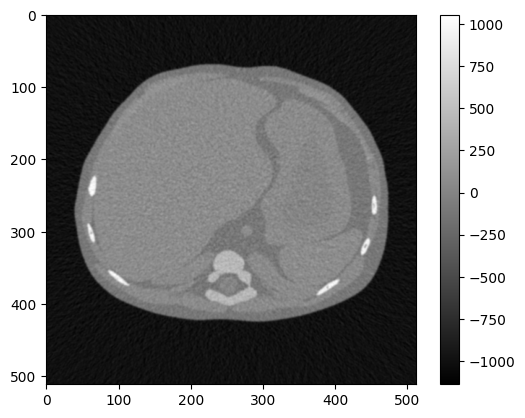

In [5]:
import matplotlib.pyplot as plt
plt.imshow(vol[0], cmap='gray')
plt.colorbar()

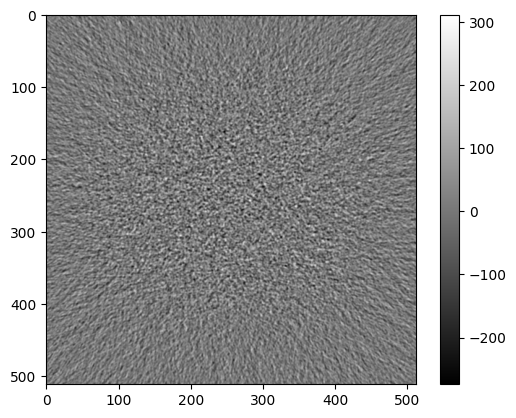

In [6]:
import matplotlib.pyplot as plt
plt.imshow(vol[0]-vol[1], cmap='gray')
plt.colorbar()

**^^Measure NPS for different real patient sizes and compare to water phantoms**

In [7]:
import sys
sys.path.append('../..')
from nps_utils import compute_nps, radial_profile
from make_noise_patches import make_noise_images

In [8]:
patient_noise_images = make_noise_images(vol)
print(vol.shape, patient_noise_images.shape)

(10, 512, 512) (45, 512, 512)


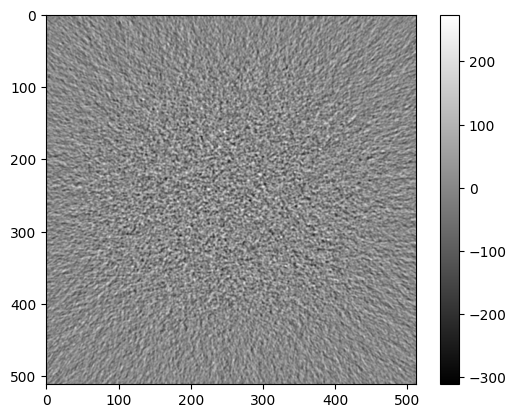

In [9]:
plt.imshow(patient_noise_images[0], cmap='gray')
plt.colorbar()

In [10]:
patient_nps = compute_nps(patient_noise_images)

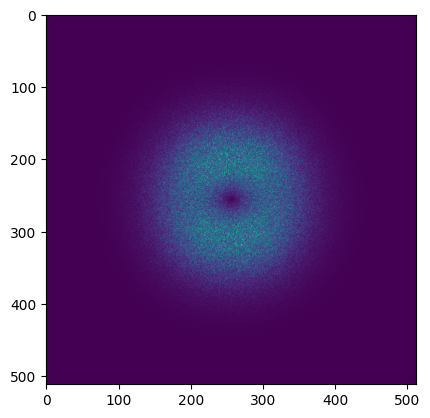

In [11]:
plt.imshow(patient_nps)

Now group by pediatric subgroup^

In [12]:
import numpy as np
def age_to_eff_diameter(age):
    # https://www.aapm.org/pubs/reports/rpt_204.pdf
    x = age
    a = 18.788598
    b = 0.19486455
    c = -1.060056
    d = -7.6244784
    y = a + b*x**1.5 + c *x**0.5 + d*np.exp(-x)
    eff_diam = y
    return eff_diam

adult_waist_circumferences_cm = {
    # 20: 90.7,
    30: 99.9,
    40: 102.8,
    # 50: 103.3,
    60: 106.2,
    70: 106.6,
    80: 104.1
}

def diameter_range_from_subgroup(subgroup):
    if subgroup == 'newborn': return (0, age_to_eff_diameter(1/12))
    elif subgroup == 'infant': return (age_to_eff_diameter(1/12), age_to_eff_diameter(2))
    elif subgroup == 'child': return (age_to_eff_diameter(2), age_to_eff_diameter(12))
    elif subgroup == 'adolescent': return (age_to_eff_diameter(12), age_to_eff_diameter(22))
    else: return (age_to_eff_diameter(22), 100)

In [13]:
def pediatric_subgroup(diameter):
    if diameter < age_to_eff_diameter(1):
        return 'newborn'
    elif (diameter >= age_to_eff_diameter(1)) & (diameter < age_to_eff_diameter(5)):
        return 'infant'
    elif (diameter >= age_to_eff_diameter(5)) & (diameter < age_to_eff_diameter(12)):
        return 'child'
    elif (diameter >= age_to_eff_diameter(12)) & (diameter < age_to_eff_diameter(22)):
        return 'adolescent'
    else:
        return 'adult'

In [14]:
df['pediatric subgroup'] = df['effective diameter (cm)'].apply(pediatric_subgroup)
df

Code #          Name  age (year) gender  weight (kg)  \
0    Reference newborn   male infant       0.166      M          3.8   
1    Reference newborn   male infant       0.166      M          3.8   
2    Reference newborn   male infant       0.166      M          3.8   
3    Reference newborn   male infant       0.166      M          3.8   
4    Reference newborn   male infant       0.166      M          3.8   
..                 ...           ...         ...    ...          ...   
415                151  female pt151      66.000      F         66.4   
416                151  female pt151      66.000      F         66.4   
417                151  female pt151      66.000      F         66.4   
418                151  female pt151      66.000      F         66.4   
419                151  female pt151      66.000      F         66.4   

     height (cm)        BMI  weight percentile ethnicity  \
0           52.0  14.100000               36.0       NaN   
1           52.0  14.100000               36.0       NaN   
2           52.0  14.100000               36.0       NaN   
3           52.0  14.100000               36.0       NaN   
4           52.0  14.100000               36.0       NaN   
..           ...        ...                ...       ...   
415        162.0  25.301021               48.8     white   
416        162.0  25.301021               48.8     white   
417        162.0  25.301021               48.8     white   
418        162.0  25.301021               48.8     white   
419        162.0  25.301021               48.8     white   

     effective diameter (cm)  Dose [%]              recon          phantom  \
0                       11.1        10  RED-CNN augmented  anthropomorphic   
1                       11.1        10            RED-CNN  anthropomorphic   
2                       11.1        10                fbp  anthropomorphic   
3                       11.1        40  RED-CNN augmented  anthropomorphic   
4                       11.1        40            RED-CNN  anthropomorphic   
..                       ...       ...                ...              ...   
415                     28.1        70            RED-CNN  anthropomorphic   
416                     28.1        70                fbp  anthropomorphic   
417                     28.1        85  RED-CNN augmented  anthropomorphic   
418                     28.1        85            RED-CNN  anthropomorphic   
419                     28.1        85                fbp  anthropomorphic   

                                                  file pediatric subgroup  
0    male_infant_ref/diameter111mm/dose_010/RED-CNN...            newborn  
1    male_infant_ref/diameter111mm/dose_010/RED-CNN...            newborn  
2    male_infant_ref/diameter111mm/dose_010/fbp/mal...            newborn  
3    male_infant_ref/diameter111mm/dose_040/RED-CNN...            newborn  
4    male_infant_ref/diameter111mm/dose_040/RED-CNN...            newborn  
..                                                 ...                ...  
415  female_pt151/diameter281mm/dose_070/RED-CNN/fe...         adolescent  
416  female_pt151/diameter281mm/dose_070/fbp/female...         adolescent  
417  female_pt151/diameter281mm/dose_085/RED-CNN au...         adolescent  
418  female_pt151/diameter281mm/dose_085/RED-CNN/fe...         adolescent  
419  female_pt151/diameter281mm/dose_085/fbp/female...         adolescent  

[420 rows x 15 columns]

In [15]:
subgroups = df['pediatric subgroup'].unique()

In [16]:
for subgroup in subgroups:
    print(f"{subgroup}: {len(df[df['pediatric subgroup']==subgroup].Name.unique())} patients")

newborn: 1 patients
infant: 8 patients
child: 2 patients
adolescent: 8 patients
adult: 1 patients


<Axes: xlabel='pediatric subgroup', ylabel='Count'>

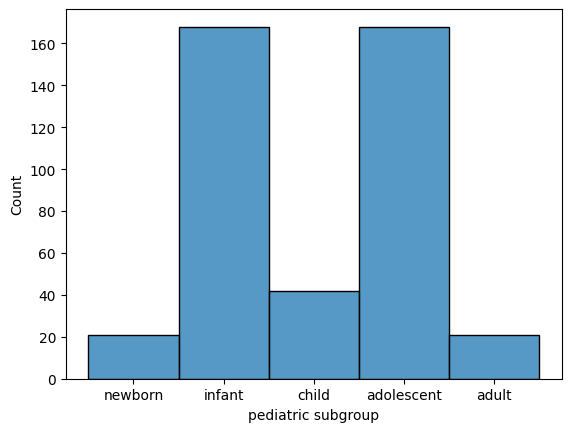

In [17]:
import seaborn as sns
sns.histplot(data=df, x='pediatric subgroup')

In [18]:
df[(df['pediatric subgroup']=='newborn') & (df['Dose [%]'] == 25) & (df['recon'] == 'fbp')]

Code #         Name  age (year) gender  weight (kg)  \
8  Reference newborn  male infant       0.166      M          3.8   

   height (cm)   BMI  weight percentile ethnicity  effective diameter (cm)  \
8         52.0  14.1               36.0       NaN                     11.1   

   Dose [%] recon          phantom  \
8        25   fbp  anthropomorphic   

                                                file pediatric subgroup  
8  male_infant_ref/diameter111mm/dose_025/fbp/mal...            newborn

Let's look at all of the images first

In [19]:
patient_images = []
annotations = []
for subgroup in subgroups:
    for idx, patient in enumerate(df[df['pediatric subgroup']==subgroup].Name.unique()):
        vol = load_img(base_dir / df[(df.Name==patient) & (df['Dose [%]'] == 25) & (df['recon'] == 'fbp')].file.item()) - 1000
        patient_images.append(vol[0])
        annotations.append(subgroup)

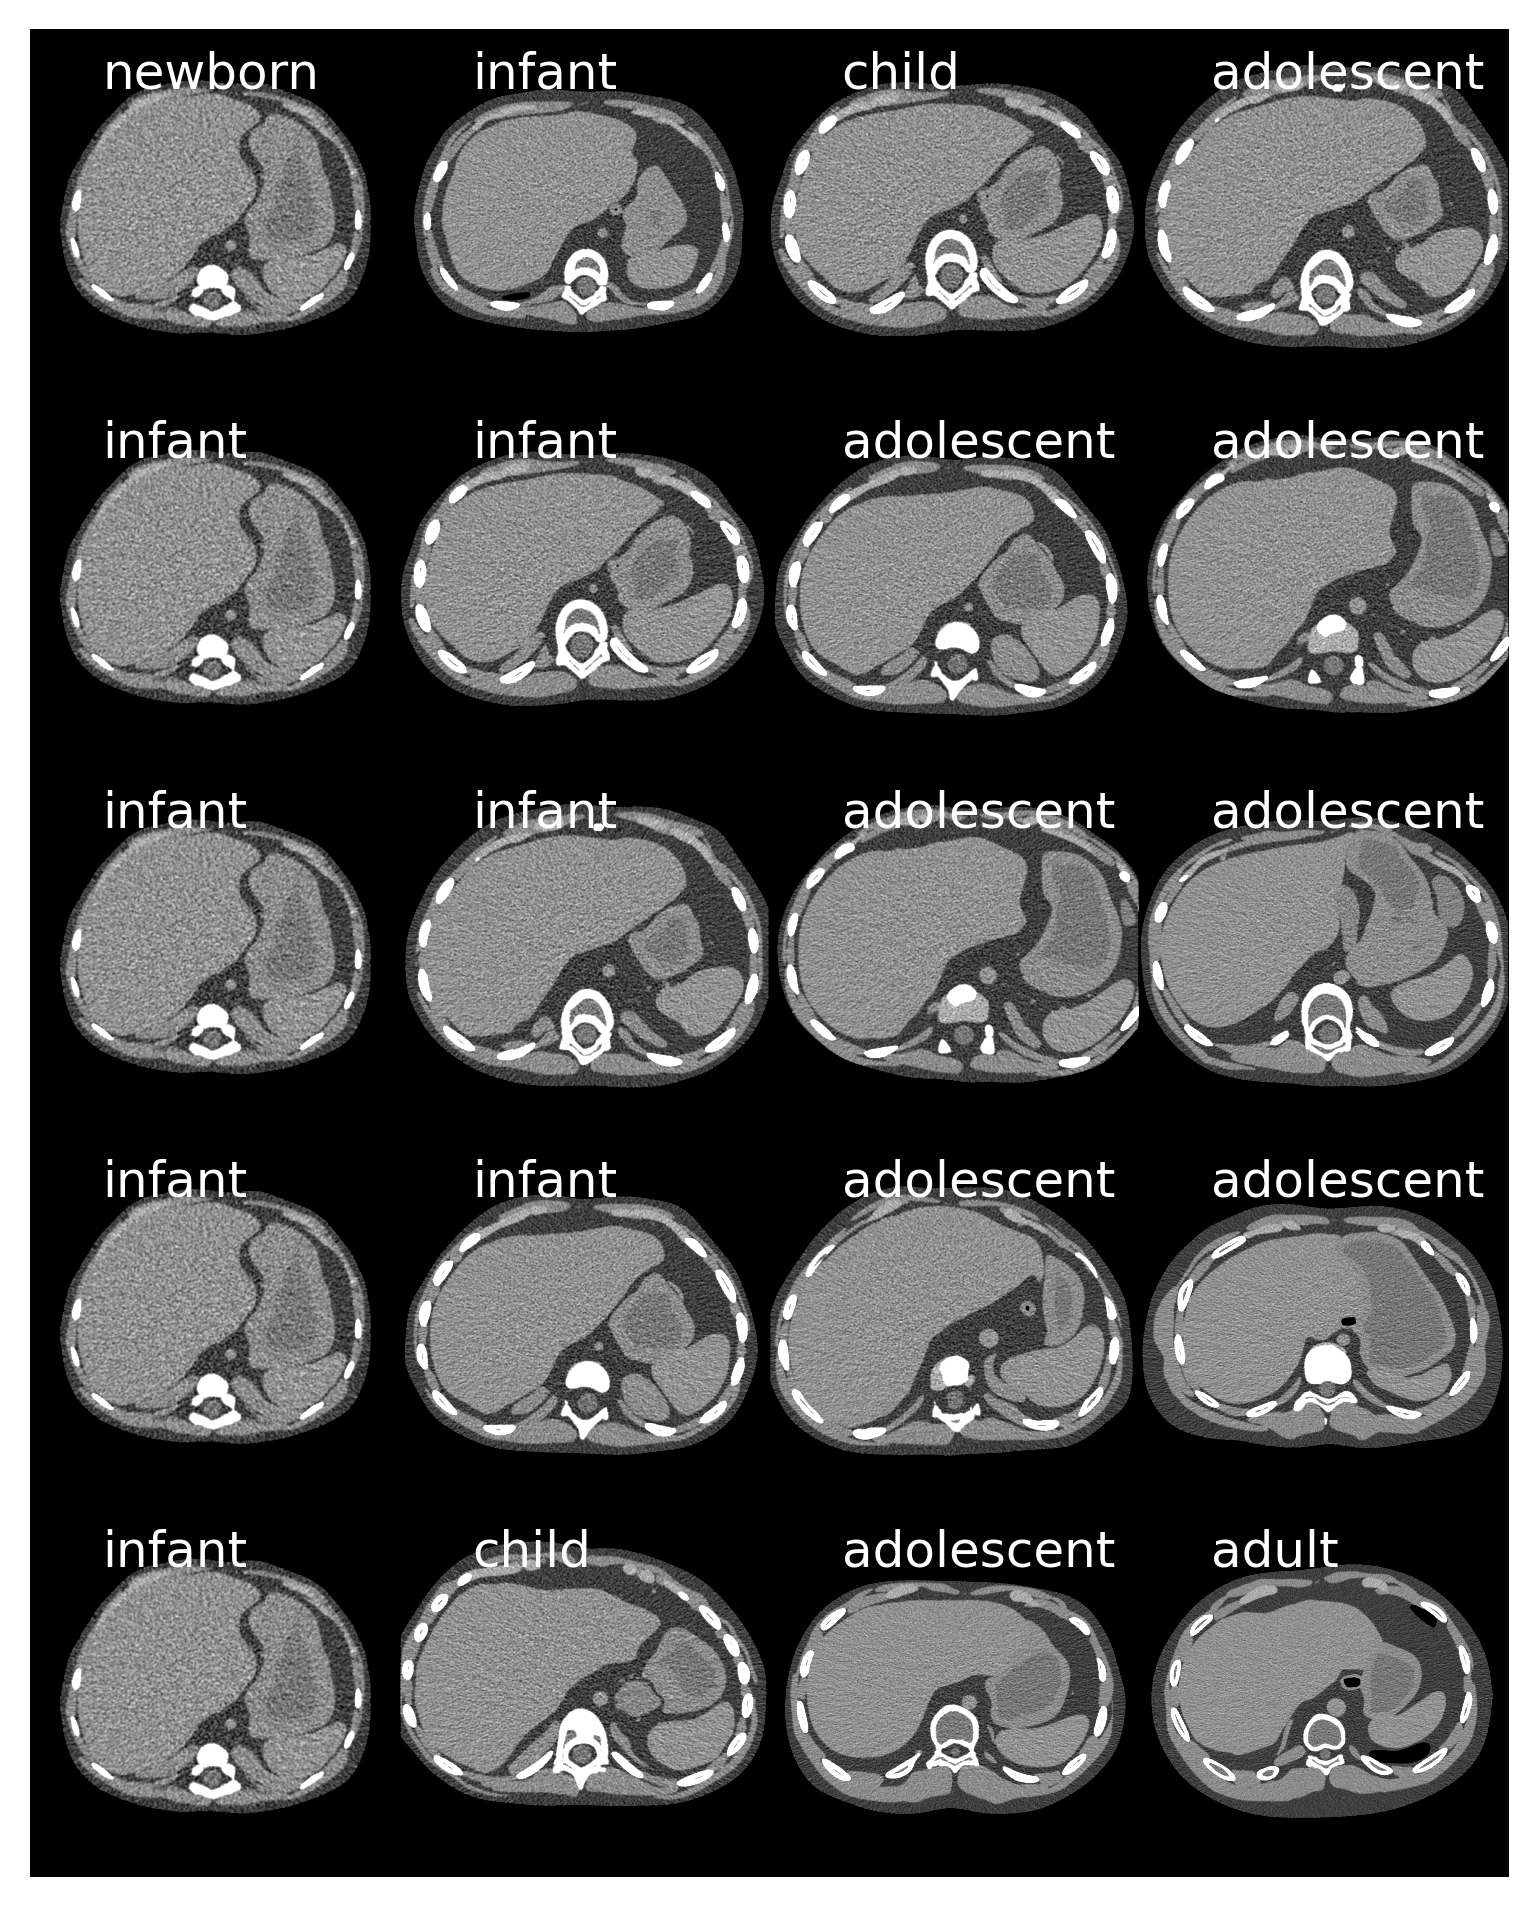

In [20]:
nrows = 5
ncols = 4
f, ax = plt.subplots(dpi=300, figsize=(10,8))
ax.imshow(np.concatenate([np.concatenate([patient_images[i+j*i] for i in range(ncols)], axis=1) for j in range(nrows)], axis=0), cmap='gray', vmin=-250, vmax=300)
ax.axis('off')
[[ax.annotate(annotations[j+i*nrows], (100+i*512, 80+j*512), color='white', fontsize=12) for i in range(ncols)] for j in range(nrows)]
plt.show()

In [21]:
sub_group_noise_dict = dict()
for subgroup in df['pediatric subgroup'].unique():
    print(f"{subgroup}: {len(df[df['pediatric subgroup']==subgroup].Name.unique())} patients")
    subgroup_noise_images = []
    for patient in df[df['pediatric subgroup']==subgroup].Name.unique():
        vol = load_img(base_dir / df[(df.Name==patient) & (df['Dose [%]'] == 25) & (df['recon'] == 'fbp')].file.item()) - 1000
        subgroup_noise_images.append(make_noise_images(vol))
    sub_group_noise_dict[subgroup] = np.array(subgroup_noise_images)

newborn: 1 patients
infant: 8 patients
child: 2 patients
adolescent: 8 patients
adult: 1 patients


In [22]:
sub_group_noise_dict['newborn'].shape, sub_group_noise_dict['infant'].shape

((1, 45, 512, 512), (8, 45, 512, 512))

It's ok to reshape grouping all repeats and patients in that subgroup into the first dimension to compute the NPS

In [23]:
(sub_group_noise_dict['infant'].mean(axis=(0, 1)) == sub_group_noise_dict['infant'].reshape(-1, 512, 512).mean(axis=0)).all()

True

<Axes: >

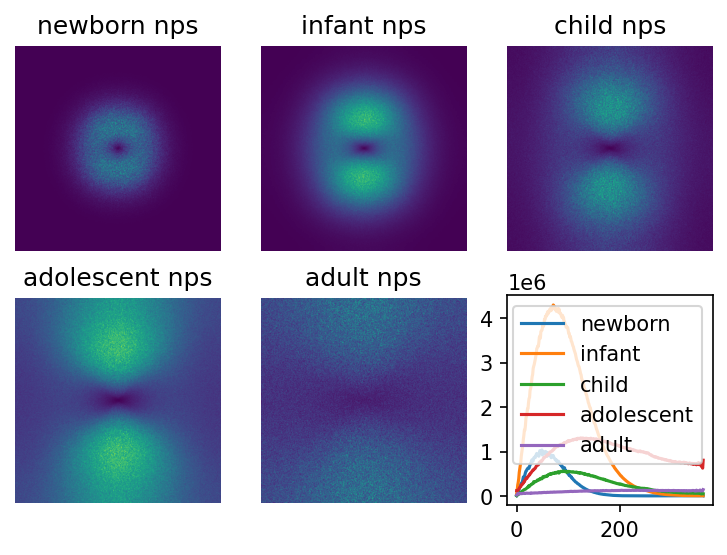

In [24]:
f, axs = plt.subplots(2, 3, figsize=(6,4), dpi=150)
axs = axs.flatten()
groups = []
nps_1d = []
subgroups = df['pediatric subgroup'].unique()
for subgroup, ax in zip(subgroups, axs):
    nps = compute_nps(sub_group_noise_dict[subgroup].reshape(-1, 512, 512))
    nps_profile = radial_profile(nps)
    groups.append(subgroup)
    nps_1d.append(nps_profile)
    ax.imshow(nps)
    ax.axis('off')
    ax.set_title(f'{subgroup} nps')
pd.DataFrame(data=np.array(nps_1d).T, columns=groups).plot(ax=axs[-1])

## Noise Texture from Pediatric-Sized Water Phantom Simulations

Noise statistically can be described in terms of its intensity content and its spatial content.

- Intensity content can be described using histograms to describe the distribution of pixel intensities that can be summarized by a mean (ideally around 0) and standard deviation, which describes the noise magnitude.
- Spatial content can be described using noise power spectra which uses Fourier analysis to quantify how much noise content exists at different spatial frequencies, where white noise (aka uncorrelated noise) is uniform across all frequencies, whereas more common in CT, noise is related to the spatial resolution of the system and thus is correlated leading to lower frequency peak that attenuates at higher frequencies due to the apodizing filter used in CT reconstruction (Cite links to learn more).

## Noise Properties of the Training Dataset

Before studying the noise in the out-of-distribution pediatric patients, we first want to establish a baseline of the noise properties used to train the deep denoiser, here trained on the [Mayo Clinic Low Dose Grand Challenge Dataset](https://aapm.onlinelibrary.wiley.com/doi/full/10.1002/mp.12345)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

save_path = '/gpfs_projects/brandon.nelson/Mayo_LDGC/numpy_files'
npfiles = glob(save_path+'/*.npy')

/gpfs_projects/brandon.nelson/Mayo_LDGC/numpy_files/L291_249_target.npy


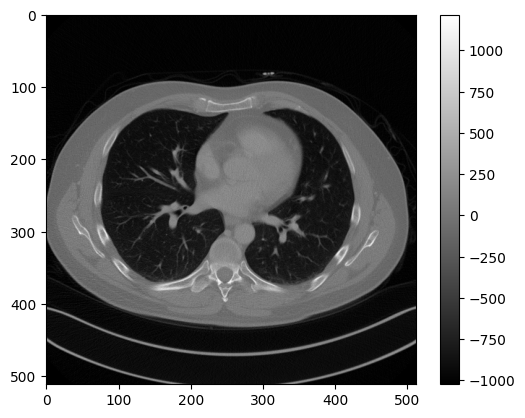

In [26]:
img = np.load(npfiles[0])
print(npfiles[0])
plt.imshow(img, cmap='gray')
plt.colorbar()

[Using ITK Widgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

pip install 'itkwidgets[lab]>=1.0a23'

pip install pyimagej

In [27]:
# from itkwidgets import view

# view(img)

In [28]:
img.std()

464.6921933268496

Text(0.5, 1.0, 'mean: 63.74 | std: 99.96')

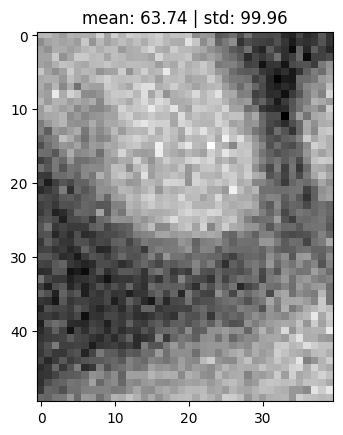

In [29]:
subimg = img[200:250, 210:250]
plt.imshow(subimg, cmap='gray')
plt.title(f'mean: {subimg.mean():0.2f} | std: {subimg.std():0.2f}')

These stds seem high, check with the L

Note that the training images have been normalized from [-1024, 3072] to [0, 0.5]

Update: normalization removed, should be native [-1024, 3072]

### Check that the dataloader is working as expected

In [30]:
import sys
sys.path.append('../../denoising')
from loader import get_loader

In [31]:
np_path = '/gpfs_projects/brandon.nelson/Mayo_LDGC/numpy_files'
train_dl = get_loader(mode='train', saved_path=np_path, patch_size=64, patch_n=10)

In [32]:
i = 0
for x, y in train_dl:
    i += 1
    if i > 0:
        break
x.shape, y.shape

(torch.Size([32, 10, 64, 64]), torch.Size([32, 10, 64, 64]))

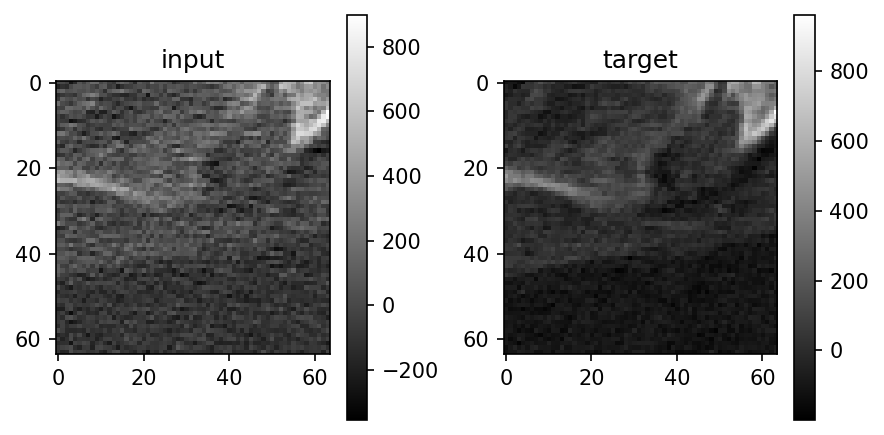

In [33]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(6,3), dpi=150)
ax = plt.subplot(1,2,1)
im = ax.imshow(x[0, 0], cmap='gray')
plt.title('input')
plt.colorbar(im)
ax = plt.subplot(1,2, 2)
im = ax.imshow(y[0, 0], cmap='gray')
plt.colorbar(im)
plt.title('target')
plt.tight_layout()

### See how the training data histograms compare to the processed training data files and test data

First load the test images (low dose inputs and routine dose targets)

In [34]:
from pathlib import Path

In [35]:
img_path = Path('/gpfs_projects/brandon.nelson/Mayo_LDGC/images')
raw_images = list((img_path/'L506').rglob('*.IMA')) #L506 the test case

test_input_dcms = [f for f in raw_images if 'quarter_3mm' in str(f)]
test_target_dcms = [f for f in raw_images if f not in test_input_dcms]
test_input_dcms.sort()
test_target_dcms.sort()

import pydicom
import numpy as np

test_inputs = []
for fname in test_input_dcms:
  dcm_file = pydicom.read_file(fname)
  test_inputs.append(dcm_file.pixel_array.astype('float32') + float(dcm_file.RescaleIntercept))
test_inputs = np.array(test_inputs)

test_targets = []
for fname in test_target_dcms:
  dcm_file = pydicom.read_file(fname)
  test_targets.append(dcm_file.pixel_array.astype('float32') + float(dcm_file.RescaleIntercept))
test_targets= np.array(test_targets)

### Look at all of the training pairs in a batch

In [36]:
import numpy as np
from PIL import Image

def pil_grid(images, max_horiz=np.iinfo(int).max):
    n_images = len(images)
    n_horiz = min(n_images, max_horiz)
    h_sizes, v_sizes = [0] * n_horiz, [0] * (n_images // n_horiz)
    for i, im in enumerate(images):
        h, v = i % n_horiz, i // n_horiz
        h_sizes[h] = max(h_sizes[h], im.size[0])
        v_sizes[v] = max(v_sizes[v], im.size[1])
    h_sizes, v_sizes = np.cumsum([0] + h_sizes), np.cumsum([0] + v_sizes)
    im_grid = Image.new('RGB', (h_sizes[-1], v_sizes[-1]), color='white')
    for i, im in enumerate(images):
        im_grid.paste(im, (h_sizes[i % n_horiz], v_sizes[i // n_horiz]))
    return im_grid

def normalize(image): return 1 - (image.max() - image) / (image.max() - image.min())

In [37]:
y.reshape(-1, 64, 64).numpy().shape

(320, 64, 64)

All training pairs for a single batch shown below as follows:
routine dose (top) `y`
------------------
low dose (bottom) `x`


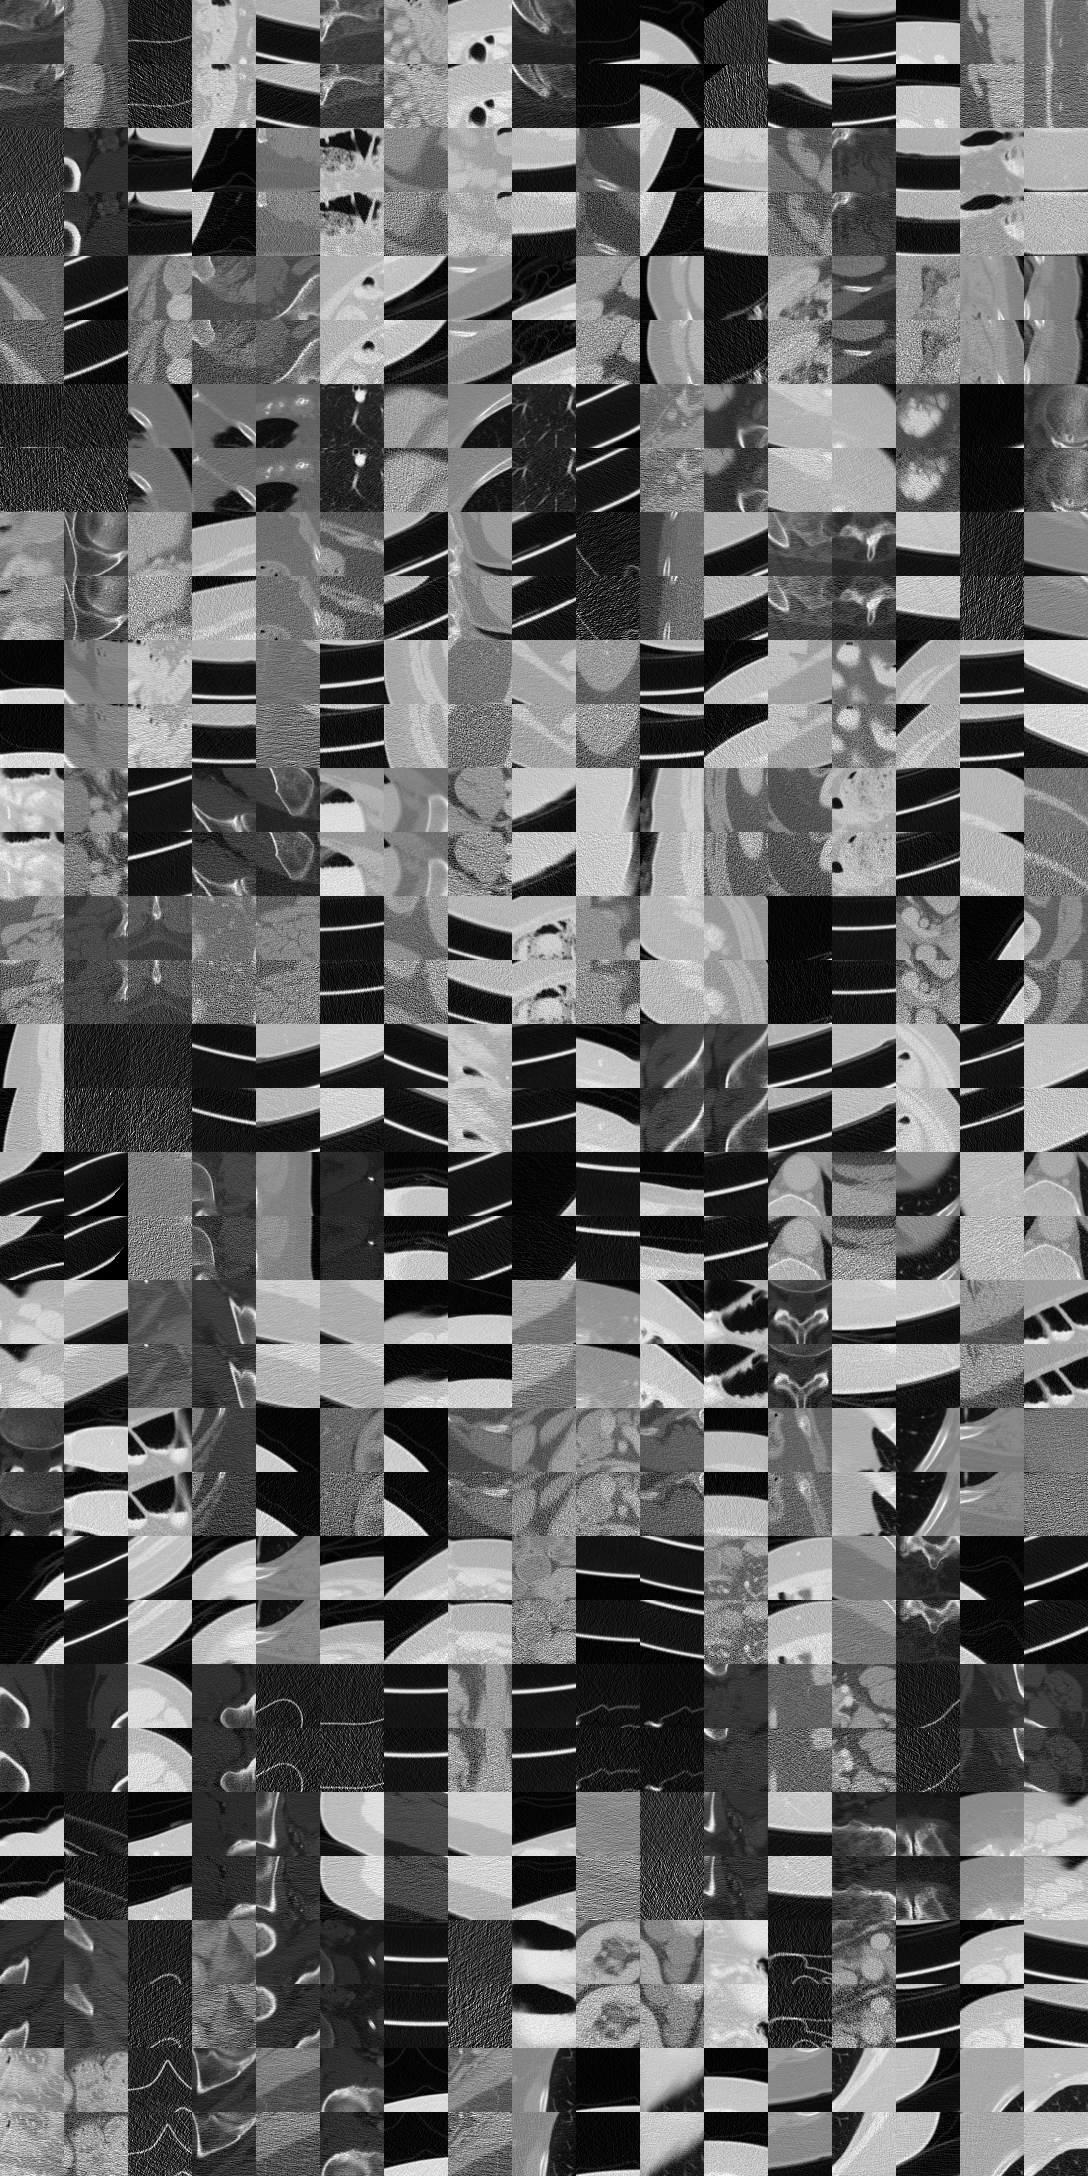

In [38]:
print('All training pairs for a single batch shown below as follows:')
print('routine dose (top) `y`')
print('------------------')
print('low dose (bottom) `x`')
l_images = []
grid_size = 17
N = grid_size**2
for i in range(N):
    image = (normalize(np.concatenate([y.reshape(-1, 64, 64).numpy()[i], x.reshape(-1, 64, 64).numpy()[i]], axis=0))*255).astype('uint8')
    l_images.append(Image.fromarray(image))
pil_grid(l_images, grid_size)

learly the patietnt table was in a lot fof the traini exampsles..

In [39]:
train_noise = x - y
test_noise = test_targets - test_inputs

In [40]:
x.dtype, y.dtype, train_noise.dtype

(torch.int16, torch.int16, torch.int16)

Just training

### Pixel Instensity Distribution

Text(0, 0.5, 'Frequency')

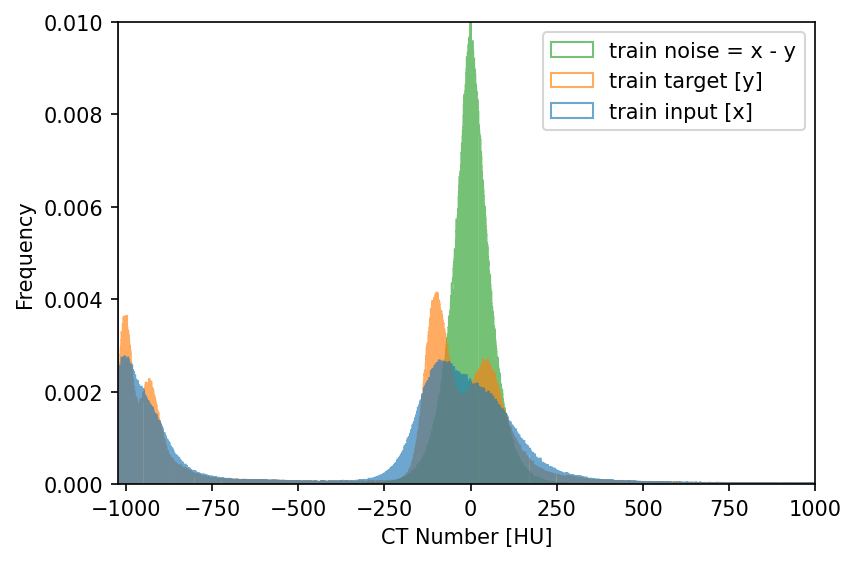

In [41]:
f, axs = plt.subplots(1,1, dpi=150, figsize=(6,4))
axs.hist([x.ravel(), y.ravel(), train_noise.ravel()], label = ['train input [x]', 'train target [y]', 'train noise = x - y'], bins=4096, density=True, histtype='step', alpha=0.65)
axs.legend()
axs.set_ylim([0, 0.01])
axs.set_xlim([-1024, 1000])
axs.set_xlabel('CT Number [HU]')
axs.set_ylabel('Frequency')

Text(-900, 0.005, 'test (mean | std):\n(-3.75 | 47.76)\ntrain (mean | std):\n(1.52 | 60.51)')

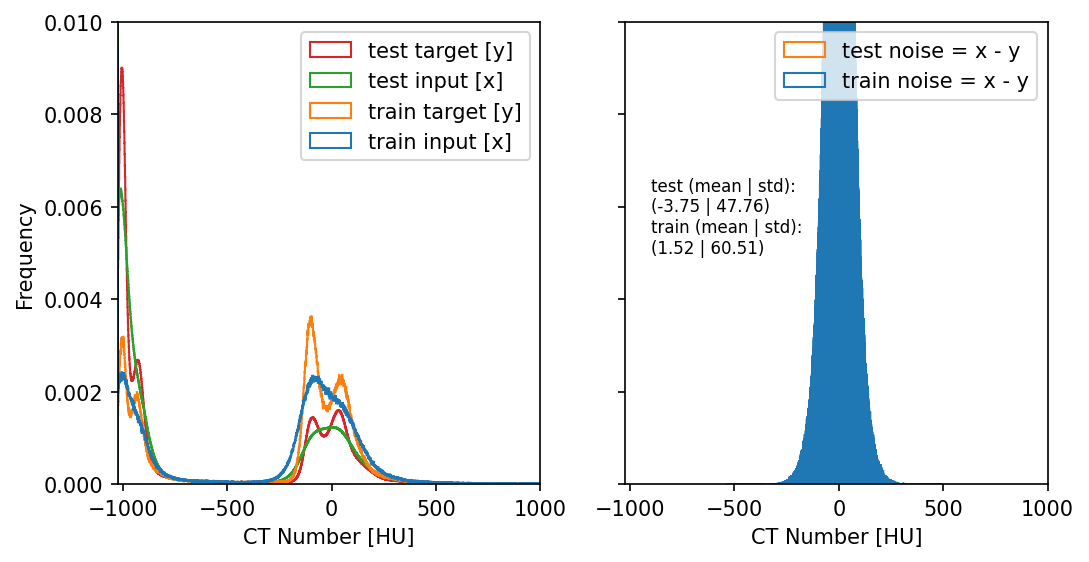

In [42]:
f, axs = plt.subplots(1,2, dpi=150, figsize=(8,4), sharex=True, sharey=True)
axs[0].hist([x.ravel(), y.ravel(), test_inputs.ravel(), test_targets.ravel()], label = ['train input [x]', 'train target [y]', 'test input [x]', 'test target [y]'], bins=4096, density=True, histtype='step')
axs[0].legend()
axs[0].set_ylim([0, 0.01])
axs[0].set_xlim([-1024, 1000])
axs[0].set_xlabel('CT Number [HU]')
axs[0].set_ylabel('Frequency')
axs[1].hist([train_noise.ravel(), test_noise.ravel()], label = ['train noise = x - y', 'test noise = x - y'], bins=4096, density=True, histtype='step')
axs[1].legend()
axs[1].set_ylim([0, 0.01])
axs[1].set_xlim([-1024, 1000])
axs[1].set_xlabel('CT Number [HU]')
axs[1].annotate(f'test (mean | std):\n({test_noise.mean():2.2f} | {test_noise.std():2.2f})\ntrain (mean | std):\n({train_noise.numpy().mean():2.2f} | {train_noise.numpy().std():2.2f})', (-900, 0.005), fontsize=8)

^ This confirms that there was no scaling done to the training data

### Now what does the noise histograms look like and how does this compare to our noise patches? 
Note: Two sets of images amay have the sae histogram statistics but wildly different textures (give exmaple of this, because histograms have no spatial awareness, whereas NPS does)

In [43]:
noise_patch_dir = Path('/home/brandon.nelson/Dev/PediatricCTSizeAugmentation/noise_patches/patch_size_64x64')
diameters = [112, 131, 151, 185, 216, 292]

noise_files = [noise_patch_dir / f'diameter{d}mm.npy' for d in diameters]
noise_patch_dict = {f.stem: np.load(f)[:100] for f in noise_files}
noise_patches = np.concatenate(list(noise_patch_dict.values()))

In [44]:
from make_noise_patches import prep_patches
patch_size = (64, 64)
datadir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CCT189_peds/')
noise_patch_dict = prep_patches(datadir, patch_size=patch_size, dose=25)

extracting noise patches...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.09it/s]


In [45]:
[len(o) for o in noise_patch_dict.values()]

[30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000]

In [46]:
[o.std() for o in noise_patch_dict.values()]

[58.09448772051442,
 57.172486992509285,
 56.31744416177111,
 55.090725087490405,
 47.68266275779561,
 54.142629381937105,
 53.28933159766019,
 53.177600862409406]

In [47]:
noise_diam = np.load(noise_patch_dir / 'diameter292mm.npy')
noise_diam.shape

(30000, 64, 64)

In [ ]:
f, axs = plt.subplots(1,1, dpi=150, figsize=(6,4))
axs.hist([noise_patch_dict[o].ravel() for o in sorted(noise_patch_dict.keys(), reverse=True)], bins=4096, label=sorted(list(noise_patch_dict.keys()), reverse=True),
         density=True, histtype='step', alpha=0.65)
axs.legend(title='phantom diameter [mm]')
axs.set_xlabel('CT Number [HU]')
axs.set_ylabel('Frequency')
axs.set_title('Phantom Noise Intensity Histograms')
axs.annotate('AEC noise magnitude:\n28 HU', (-150, 0.125))

In [ ]:
plt.hist([x.ravel(), y.ravel(), test_inputs.ravel(), train_noise.ravel(), noise_patch_dict[29.2].ravel()], label = ['low dose input [x]', 'routine dose target [y]', 'test patient inputs [x]', 'train noise image`: x - y', 'phantom noise patches'], bins=4096, density=True, histtype='step')
plt.legend()
plt.ylim([0, 0.01])
plt.xlim([-1024, 1000])
plt.show()

In [ ]:
normalized_patches = {d: noise_patch_dict[d]/noise_patch_dict[d].std()*train_noise.numpy().std() for d in noise_patch_dict}

In [ ]:
plt.hist([train_noise.ravel(), noise_patch_dict[29.2].ravel(), normalized_patches[29.2].ravel()], label = ['train noise =  x - y', 'phantom noise patches', 'renormalized noise patches'], bins=4096, density=True, histtype='step')
plt.legend()
plt.show()

In [ ]:
train_noise.shape

In [ ]:
train_noise.numpy().mean(axis=(0, 1)).shape

In [ ]:
normalized_patches[29.2].std(), train_noise.numpy().std()

In [ ]:
noise_patch_dict[29.2].shape, train_noise.reshape(-1, 64, 64, 1).shape

In [ ]:
from skimage.exposure import match_histograms, histogram

input_shape = noise_patch_dict[29.2].shape

input_images = noise_patch_dict[29.2].reshape(-1, 1)
ref_images = train_noise.reshape(-1, 1).numpy()

print(input_images.shape, ref_images.shape)

equal_hist_patches = {diam: match_histograms(input_images.reshape(-1, 1), reference=ref_images).reshape(input_shape) for diam, input_images in noise_patch_dict.items()}
[o.shape for o in equal_hist_patches.values()]

In [ ]:
import pandas as pd

def summarize_patches(patch_dicts:list, names:list):
    rows = list(sorted(patch_dicts[0].keys()))
    for measure, measure_name in zip([lambda x: x.mean(), lambda x: x.std()], ['mean', 'std']):
        temp_names = [o + " " + measure_name for o in names]
        if measure_name == 'mean':
            df = pd.DataFrame(data=np.array([[patches[o].mean() for o in rows] for patches in patch_dicts]).T, index=rows, columns=temp_names)
        else:
            df = df.join(pd.DataFrame(data=np.array([[patches[o].std() for o in rows] for patches in patch_dicts]).T, index=rows, columns=temp_names))
    df['training noise mean'] = train_noise.numpy().mean()
    df['training noise std'] = train_noise.numpy().std()
    return df

summarize_patches([noise_patch_dict, normalized_patches, equal_hist_patches], ['Original', 'normalized','hist matched'])

1. It's interesting that a DC component was added in the histogram matching so we remove it and check again.

In [ ]:
equal_hist_patches = {diam: match_histograms(input_images.reshape(-1, 1), reference=ref_images).reshape(input_shape) for diam, input_images in noise_patch_dict.items()}
equal_hist_patches = {diam: p - p.mean() for diam, p in equal_hist_patches.items()}

summarize_patches([noise_patch_dict, normalized_patches, equal_hist_patches], ['Original', 'normalized','hist matched'])

Now we see that the hist matched mean is 0 and has a standard deviation matching the training noise

In [ ]:
plt.hist([train_noise.ravel(), noise_patch_dict['diameter292mm'].ravel(), equal_hist_patches['diameter292mm'].ravel()], label = ['`noise image`: x - y', 'noise patches', 'matched hist noise patches'], bins=4096, density=True, histtype='step')
plt.legend()
plt.show()

In [ ]:
from skimage.exposure import cumulative_distribution


In [ ]:
smooth = True
for img, lbl, style in zip([train_noise.numpy(), noise_patch_dict['diameter292mm'], equal_hist_patches['diameter292mm']],
                           ['training dataset noise`: x - y', 'phantom scan noise patches', 'histogram matched phantom noise patches'],
                           ['red', 'green', 'blue']):
    img = img.astype('int16')
    img_hist, hbins = histogram(img)
    if smooth: img_hist = np.convolve(img_hist, gaussian(img_hist, 11), mode='same')
    plt.plot(hbins, img_hist/ img_hist.max(), color=style, label=lbl)
plt.xlim([-200, 200])
plt.legend()
plt.show()

In [ ]:
for img, lbl, style in zip([train_noise.numpy(), np.array(list(noise_patch_dict.values())).ravel(), np.array(list(equal_hist_patches.values())).ravel()],
                           ['training dataset noise`: x - y', 'phantom scan noise patches', 'histogram matched phantom noise patches'],
                           ['red', 'green', 'blue']):
    img = img.astype('int16')
    img_hist, hbins = histogram(img)
    plt.plot(hbins, img_hist/ img_hist.max(), color=style, label=lbl)
plt.xlim([-200, 200])
plt.legend()
plt.show()

Due to histogram matching there are now gaps in the histogram due to spreading the intensity values around, so let's apply a smoothing to the histogram for visualization purposes

In [ ]:
def gaussian(img_hist, sigma=3):
    x = np.arange((len(img_hist)))
    return np.exp(-np.power(x-len(img_hist)//2,2)/sigma**2)

plt.plot(gaussian(img_hist, 11))

In [ ]:
np.array(list(noise_patch_dict.values())).ravel()

In [ ]:
smooth = True
f, ax = plt.subplots(figsize=(4,3.5), dpi=300)
for img, lbl, style in zip([train_noise.numpy(), np.array(list(noise_patch_dict.values())).ravel(), np.array(list(equal_hist_patches.values())).ravel()],
                           ['training dataset', 'phantom data', 'histogram matched phantom data'],
                           ['-', '--', ':']):
    img = img.astype('int16')
    img_hist, hbins = histogram(img, normalize=True)
    if smooth: img_hist = np.convolve(img_hist, gaussian(img_hist, 11), mode='same')
    ax.plot(hbins, img_hist, label=lbl, linestyle=style)
ax.set_title('Noise Image Pixel Intensity Distribution')
ax.set_ylabel('frequency')
ax.set_xlabel('difference image CT number [HU]')
ax.set_xlim([-200, 200])
ax.set_ylim([0, 0.38])
ax.legend()
f.show()

In [ ]:
print(train_noise.numpy().mean(), train_noise.numpy().std())

[equal_hist_patches[d].std() for d in equal_hist_patches]

In [ ]:
[o.std() for o in noise_patch_dict.values()]

In [ ]:
print('original noise patches')
[print(f'{k} mean {v.mean():2.3f} | std {v.std():2.3f}') for k,v in noise_patch_dict.items()]
print('hist equalized noise patches')
[print(f'{k} mean {v.mean():2.3f} | std {v.std():2.3f}') for k,v in equal_hist_patches.items()];

Nwxt look at the noise patches in trhe training set to understand the difference in hist (higher rorder)

In [ ]:
print('All training noise:')
l_images = []
grid_size = 6
N = grid_size**2
for i in range(N):
    image = (normalize(np.concatenate([train_noise.reshape(-1, 64, 64).numpy()[i]], axis=0))*255).astype('uint8')
    l_images.append(Image.fromarray(image))
pil_grid(l_images, grid_size)

In [ ]:
print('All generated noise patches:')
l_images = []
grid_size = len(noise_patch_dict)
N = grid_size**2
for diam in noise_patch_dict:
    print(diam)
    for i in range(grid_size):
        image = (normalize(np.concatenate([noise_patch_dict[diam][i]], axis=0))*255).astype('uint8')
        l_images.append(Image.fromarray(image))
pil_grid(l_images, grid_size)

In [ ]:
print('Histogram matched noise patches:')
l_images = []
grid_size = len(noise_patch_dict)
N = grid_size**2
for diam in noise_patch_dict:
    print(diam)
    for i in range(grid_size):
        image = (normalize(np.concatenate([equal_hist_patches[diam][i]], axis=0))*255).astype('uint8')
        l_images.append(Image.fromarray(image))
pil_grid(l_images, grid_size)

As we saw above these nmoise patches look quite differ ent by row but all have the same histogram

Now look at the frequency components 

In [ ]:
def compute_nps(image):

  if image.ndim == 2:
    image = image[None, :, :]

  if image.ndim == 4:
    image = image[:,:,:,0]

  nsize = image.shape
  nrealization = nsize[0]
  if image.ndim == 3:
    nps = np.zeros((nsize[1],nsize[2]))
    for i in range(nrealization):
      s = np.fft.fftshift(np.fft.fft2(image[i]))
      nps = np.abs(s)**2 + nps
    nps = nps/(nsize[1]*nsize[2])
  else:
    raise ValueError(f'Image of dimension {image.ndim} Not implemented!')
  return nps


def radial_profile(data, center=None):
    center = center or (data.shape[0]/2, data.shape[1]/2)
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

nps = compute_nps(noise_patch_dict['diameter292mm'])
nps_1d = radial_profile(nps)

f, axs = plt.subplots(1,2)
axs[0].imshow(nps)
axs[1].plot(nps_1d)

In [ ]:
f, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 5), dpi=150)
for d, ax in zip(diameters, axs.flatten()):
    patches = noise_patch_dict[f'diameter{d}mm']
    nps = compute_nps(patches)
    ax.imshow(nps)
    ax.axis('off')
    ax.set_title(f'{len(patches)} x {d} mm patch\nstd: {patches.std():3.3f}')

In [ ]:
plt.imshow(train_noise.reshape(-1, 64, 64)[0], cmap='gray')

In [ ]:
np.array(train_noise).mean()

In [ ]:
train_nps=compute_nps(train_noise.reshape(-1, 64, 64)-np.array(train_noise).mean())
train_nps[(64//2-2):(64//2+3), (64//2-1):(64//2+1)]=0
# train_nps[0,:]=0
# train_nps[-1,:]=0
# train_nps[:,0]=0
# train_nps[:,-1]=0
train_nps_1d = radial_profile(train_nps)
plt.imshow(train_nps, cmap='gray')
plt.show()
plt.plot(train_nps_1d)
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(4,3.5), dpi=150)
nps_1d = train_nps_1d
if smooth: nps_1d = np.convolve(nps_1d, gaussian(nps_1d, 3), 'same')
plt.plot(nps_1d/nps_1d.max(), label='training dataset', linestyle='-')

for d, style in zip([112, 185, 292], ['--', ':', '-.']):
    patches = noise_patch_dict[f'diameter{d}mm']
    nps = compute_nps(patches)
    nps_1d = radial_profile(nps)
    if smooth: nps_1d = np.convolve(nps_1d, gaussian(nps_1d, 3), 'same')
    nps_1d/=nps_1d.max()
    plt.plot(nps_1d, label=d, linestyle=style)

plt.ylabel('Noise Power [$HU^2$]')
plt.xlabel('Spatial Frequency [cycles/pixel]')
# plt.title('Phantom Noise') 
plt.legend(title='phantom diameter [mm]')
plt.show()

In [ ]:
for d in diameters[::2]:
    patches = noise_patch_dict[f'diameter{d}mm']
    nps = compute_nps(patches)
    nps_1d = radial_profile(nps)
    plt.plot(nps_1d, label=f'{d} mm original')

    patches = equal_hist_patches[f'diameter{d}mm']
    nps = compute_nps(patches)
    nps_1d = radial_profile(nps)
    plt.plot(nps_1d, label=f'{d} mm hist matched', marker='*', linestyle='')
plt.legend()
plt.show()

Histogram matching the noise patches for augmentated training to match the intensity distribution of the training set

A few things to note:
1. Since the noise magnitude has been increased, the height was increased, so to better compare, we'll look at the normalized NPS

In [ ]:
for d in diameters[::2]:
    patches = noise_patch_dict[f'diameter{d}mm'].copy()
    nps = compute_nps(patches)
    nps /= nps.sum() # <--- here
    nps_1d = radial_profile(nps)
    plt.plot(nps_1d, label=f'{d} mm original')

    patches = equal_hist_patches[f'diameter{d}mm'].copy()
    nps = compute_nps(patches)
    nps /= nps.sum() # <--- and here
    nps_1d = radial_profile(nps)
    plt.plot(nps_1d, label=f'{d} mm hist matched', marker='*', linestyle='')
plt.legend()
plt.xlabel('Spatial Frequncy [cycles/pixel]')
plt.ylabel('Noise Power [$HU^2$]')
plt.show()

Add anthropomorphic phantoms as a different line style and overlay TODO: 4/4/2024

In [ ]:
from make_noise_patches import make_noise_patches
make_noise_patches?

Need to add phantom scans to df data frame and assign pediatric subgroups to show that the phantom scans reproduce the noise textures of the pediatric anthro scans. Thus both noise texture and intensity are reproduced by these noise patches

In [ ]:
group

In [ ]:
for group in sub_group_noise_dict:
    patient_noise_images = sub_group_noise_dict[group].reshape(-1, 512, 512)
    patches = make_noise_patches(patient_noise_images, patch_size=(64, 64))
    nps = compute_nps(patches)
    nps /= nps.sum() # <--- here
    nps_1d = radial_profile(nps)
    # plt.plot(nps_1d, label=f'{d} mm pediatric noise')

    patches = equal_hist_patches[f'diameter{d}mm'].copy()
    nps = compute_nps(patches)
    nps /= nps.sum() # <--- and here
    nps_1d = radial_profile(nps)
    plt.plot(nps_1d, label=f'{d} mm hist matched', marker='*', linestyle='')
plt.legend()
plt.xlabel('Spatial Frequncy [cycles/pixel]')
plt.ylabel('Noise Power [$HU^2$]')
plt.show()

After making these two adjustments, we can confirm that matching the histograms *did not alter the texture* 

^^ Now compare these 

In [ ]:
noise_patches = np.concatenate(list(equal_hist_patches.values()))

## Data Augmentation with Pediatric Protocol Noise Patches

In [ ]:
print('All training pairs for a single batch shown below as follows:')
print('routine dose (top) `y`')
print('------------------')
print('low dose (middle) `x`')
print('------------------')
print('noise augmented (bottom) `x`=y + noise_patch`')
l_images = []
grid_size = 17
N = grid_size**2
for i in range(N):
    noise_patch = noise_patches[np.random.choice(list(range(len(noise_patches))))]
    image = (normalize(np.concatenate([y.reshape(-1, 64, 64).numpy()[i], x.reshape(-1, 64, 64).numpy()[i], y.reshape(-1, 64, 64).numpy()[i]+noise_patch], axis=0))*255).astype('uint8')
    l_images.append(Image.fromarray(image))
pil_grid(l_images, grid_size)

In [ ]:
plt.imshow(y[31, 1], cmap='gray', vmin=-250, vmax=350)
plt.axis('off')
plt.savefig('images/fd_patch.png', dpi=300, bbox_inches='tight')
plt.show()
plt.imshow(x[31, 1], cmap='gray', vmin=-250, vmax=350)
plt.axis('off')
plt.savefig('images/qd_patch.png', dpi=300, bbox_inches='tight')
plt.show()
plt.imshow(noise_patch, cmap='gray', vmin=-250, vmax=350)
plt.axis('off')
plt.savefig('images/noise_patch.png', dpi=300, bbox_inches='tight')
plt.show()
plt.imshow(y[31, 1] + noise_patch, cmap='gray', vmin=-250, vmax=350)
plt.axis('off')
plt.savefig('images/aug_patch.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import pydot
fname = 'traditional'
img_font = 16
img_dir = '/home/brandon.nelson/Dev/PediatricCTSizeAugmentation/notebooks/01 Method Developement/images'

'http://magjac.com/graphviz-visual-editor/'
dot_string = f"""digraph dot_image {{
    fontname="Helvetica,Arial,sans-serif"
    node [fontname="Helvetica,Arial,sans-serif"]
    edge [fontname="Helvetica,Arial,sans-serif"]
    layout=dot
    node [shape=box]; {{node [label=<<TABLE border="0" cellborder="0">
                                      <TR><td width="100" height="10" fixedsize="true"><font point-size="{img_font-2}">LD Adult Protocol</font></td></TR>
                                      <TR><TD width="100" height="100" fixedsize="true"><IMG SRC="{img_dir}/qd_patch.png" scale="true"/></TD></TR>
                                      <TR><td width="100" height="10" fixedsize="true"><font point-size="{img_font}">Training Input</font></td></TR>
                                    </TABLE>>] input}};
    node [shape=box]; {{node [label=<<TABLE border="0" cellborder="0">
                                      <TR><td width="100" height="10" fixedsize="true"><font point-size="{img_font-2}">FD Adult Protocol</font></td></TR>
                                      <TR><TD width="100" height="100" fixedsize="true"><IMG SRC="{img_dir}/fd_patch.png" scale="true"/></TD></TR>
                                      <TR><td width="100" height="10" fixedsize="true"><font point-size="{img_font}">Training Target</font></td></TR>
                                    </TABLE>>] target}};

    node [shape=ellipse]; Model;
    node [shape=diamond,style=filled,color=lightgrey]; {{node [label="Loss Function"] loss}};

    input -> Model [len=1.00];

    Model -> Prediction [len=1.00];
    Prediction -> loss [len=1.00];

    target -> loss [len=1.00];
    loss -> Model [len=1.00];

    fontsize=24;
}}"""
graphs = pydot.graph_from_dot_data(dot_string)[0]
graphs.write_pdf(f'images/for_submission/{fname}.pdf')
graphs.write_png(f'images/for_word/{fname}.png')
Image.open(f'images/for_word/{fname}.png')

In [ ]:
fname = 'augmented'
img_font = 15
dot_string = f"""digraph {{
    fontname="Helvetica,Arial,sans-serif"
    node [fontname="Helvetica,Arial,sans-serif"]
    edge [fontname="Helvetica,Arial,sans-serif"]
    layout=dot
    node [shape=box]; {{node [label=<<TABLE border="0" cellborder="0">
                                      <TR><td width="100" height="10" fixedsize="true"><font point-size="{img_font-2}">LD Adult Protocol</font></td></TR>
                                      <TR><TD width="100" height="100" fixedsize="true"><IMG SRC="{img_dir}/qd_patch.png" scale="true"/></TD></TR>
                                      <TR><td width="100" height="10" fixedsize="true"><font point-size="{img_font}">Training Input</font></td></TR>
                                    </TABLE>>] input}};
    node [shape=box]; {{node [label=<<TABLE border="0" cellborder="0">
                                          <TR><td width="100" height="10" fixedsize="true"><font point-size="{img_font-2}">FD Adult Protocol</font></td></TR>
                                      <TR><TD width="100" height="100" fixedsize="true"><IMG SRC="{img_dir}/fd_patch.png" scale="true"/></TD></TR>
                                      <TR><td width="100" height="10" fixedsize="true"><font point-size="{img_font}">Training Target</font></td></TR>
                                    </TABLE>>] target}};
    node [shape=box]; Prediction;
    node [shape=box]; {{node [label=<<TABLE border="0" cellborder="0">
                                      <TR><td width="100" height="10" fixedsize="true"><font point-size="{img_font-2}">Pediatric Protocol</font></td></TR>
                                      <TR><TD width="100" height="100" fixedsize="true"><IMG SRC="{img_dir}/noise_patch.png" scale="true"/></TD></TR>
                                      <TR><td width="100" height="10" fixedsize="true"><font point-size="{img_font}">Noise Patches</font></td></TR>
                                    </TABLE>>] patches}};
    node [shape=box]; {{node [label=<<TABLE border="0" cellborder="0">
                                      <TR><TD width="100" height="100" fixedsize="true"><IMG SRC="{img_dir}/aug_patch.png" scale="true"/></TD></TR>
                                      <TR><td width="100" height="10" fixedsize="true"><font point-size="{img_font}">Augmented Input</font></td></TR>
                                    </TABLE>>] augmented}};

    node [shape=ellipse]; Model;
    node [shape=diamond,style=filled,color=lightgrey]; {{node [label="Loss Function"] loss}};

    patches -> augmented;
    target ->  augmented [len=1.00];

    input -> Model  [label="1 - λ"];
    augmented -> Model  [label="λ"];

    Model -> Prediction [len=1.00];
    Prediction -> loss [len=1.00];
    target -> loss [len=1.00];
    loss -> Model [len=1.00];

    fontsize=24;
}}"""
graphs = pydot.graph_from_dot_data(dot_string)[0]
graphs.write_pdf(f'images/for_submission/{fname}.pdf')
graphs.write_png(f'images/for_word/{fname}.png')
Image.open(f'images/for_word/{fname}.png')